---
<h1><center>IDS 435 - Assignment 4</center></h1>
<h4><center>Spring 2022</center></h4> 



##### **Please read the submission guidelines available on the Blackboard carefully to prepare and turn in your submission.**



--- 

### **ETC and UCB**


This assignment is based on the slide deck used in the lectures titled "ETCvsUCB". Please refer to those slides for notation and algorithms. 

#### **Experiment Setup**

Consider the following two-armed bandit setting: (i) you have in total $K=2$ arms, that is, $a=1$ or $a=2$; (ii) each time that you play the first arm,
you receive a reward that comes from a mean-zero normal distribution with a standard deviation of one; and (iii) for the second arm,
this normal distribution has the mean of $-\delta$ and has the same standard deviation of one. Here, $\delta$ is a positive constant. 
Therefore, arm $a=1$ is optimal and we have the gaps $\Delta_1 = 0$ and $\Delta_2 = \delta$ associated with arms $a=1$ and $a=2$, respectively.
Indeed, we do not know the reward distributions, their means, or standard deviations when using the algorithm. We only have access to a sample from the reward distribution of an arm if it is chosen. 

Below is code that illustrates how to compute regret for a simple rule that plays the first arm in odd rounds and the second one in even rounds.
We have chosen $T=1,000$ rounds when $\delta=.5$.


In [173]:
import numpy as np

def reward(arm:int,delta:float):
    assert arm in [1,2] 
    assert delta >0
    if arm == 1:
        return np.random.normal(loc= 0,scale=1)
    else:
        return np.random.normal(loc= -delta,scale=1)
        
def simple_rule(T:int,delta:float):
    reward_arm_1 = []
    reward_arm_2 = []
    for t in range(1, T+1):
        if t%2 ==1:
            #play arm 1
            reward_arm_1.append(reward(1,delta))
        else:
            #play arm 2
            reward_arm_2.append(reward(2,delta))           
    
    return reward_arm_1,reward_arm_2

if __name__== "__main__":
    delta_ = .5
    reward_arm_1,reward_arm_2 = simple_rule(T=1000, delta=delta_)
    print('Sum of rewards from arm 1:\t', sum(reward_arm_1))
    print('Sum of rewards from arm 2:\t', sum(reward_arm_2))
    print('Observed regret:          \t', sum(reward_arm_1)-sum(reward_arm_2))

Sum of rewards from arm 1:	 -19.9662143027771
Sum of rewards from arm 2:	 -227.69451476680507
Observed regret:          	 207.72830046402797


### Q1.
1. Suppose we set $T = 1,000$. If you rerun function ```simple_rule``` above, do you see the same regret? Compute the average regret by rerunning code ```simple_rule(T=1000, delta=.5)``` for $10^5$ times.
Do you see this average regret being close to $\delta\times N_t(a)$, where $N_t(a)$ is the number of times that action $a=2$ has been selected by ```simple_rule``` prior to time $t$? Explain your observation.<br></br>

In [500]:
if __name__== "__main__":
    delta_ = .5
    num_iter = 100000
    T = 1000
    sum_reward_arm_1, sum_reward_arm_2 = 0, 0
    for i in range(num_iter):
        result = simple_rule(T, delta=delta_)
        #track_arm_2.append(len(result[1]))
        sum_reward_arm_1 = sum_reward_arm_1 + sum(result[0])
        sum_reward_arm_2 = sum_reward_arm_2 + sum(result[1])
    average_regret = sum_reward_arm_1/float(num_iter) - sum_reward_arm_2/float(num_iter)
    print("Nt(2) * delta = T/2 * 0.5 = ", T/2 * delta_, ", Average regret = ", average_regret)

Nt(2) * delta = T/2 * 0.5 =  250.0 , Average regret =  250.13311138020384


The average regret gets closer to theoretical regret as the number of repetitions increase. This is due to the fact that more samples are generated from both bandit machine distributions.

### Q2.
2. Write a python function implementing ETC. Note that inside your ETC function, you can simulate the reward you would receive by pulling an arm by calling the function ```reward``` for the pulled arm.
Your ETC function will choose arms differently from the simple rule above.<br></br>

In [501]:
def ETC(m, T, num_iter, optimal_arm, delta_):

    average_regret = 0.
    average_best_arm_reward = 0.
    average_count_arm = [0, 0]
    for r in range(num_iter):
        count_arm = [0 , 0]
        mean_arm = [0., 0.]
        regret = 0.
        for t in range(m):
            temp = [0., 0.]
            for i in range(2):
                count_arm[i] += 1
                temp[i] = reward(i + 1, delta_)
                mean_arm[i] += temp[i]
            regret += temp[optimal_arm] - temp[-(optimal_arm - 1)]
            
        for i in range(2):
            mean_arm[i] /= count_arm[i]
                
        best_arm = max(enumerate(mean_arm), key=lambda x: x[1])[0]
        
        for i in range(2):
            mean_arm[i] *= count_arm[i]

        for t in range(T - m*2):
            count_arm[best_arm] += 1
            temp[i] = reward(best_arm + 1, delta_)
            mean_arm[best_arm] += temp[i]
        
            regret += temp[optimal_arm] - temp[best_arm]
            
        average_regret += regret
        average_best_arm_reward += mean_arm[best_arm]
        average_count_arm[0] += count_arm[0]
        average_count_arm[1] += count_arm[1]
    print("ECB: T = ", T, ", m = ", m, ", delta = ", delta_)
    print("Best arm reward: ", average_best_arm_reward/num_iter, ", Average regret: ", average_regret/num_iter, "Theoretical regret: ", average_count_arm[-(best_arm - 1)]*delta_/num_iter)
    print("-----------------------------------------------------------------------")
    return average_regret/num_iter
    
    
    

In [502]:
delta_ = .5
T = 1000
optimal_arm = 0
num_iter = 100000
optimal_m = int(np.ceil(4*np.log(T*delta_**2/4)/delta_**2))
ETC(optimal_m, T, num_iter, optimal_arm, delta_);

ECB: T =  1000 , m =  67 , delta =  0.5
Best arm reward:  -0.7229530827748332 , Average regret:  33.74309341565331 Theoretical regret:  34.33136
-----------------------------------------------------------------------


### Q3.
3. Write a python function implementing UCB.<br></br> 

In [503]:
def UCB(T, num_iter, optimal_arm, delta_):
    
    average_regret = 0.
    average_best_arm_reward = 0.
    average_count_arm = [0, 0]
    theoretical_regret = 0.
    for r in range(num_iter):
        mean_arm = [0., 0.]
        count_arm = [0, 0]
        regret = 0.
        for i in range(2):
            count_arm[i] += 1
            mean_arm[i] += reward(i + 1, delta_)

            regret += mean_arm[optimal_arm] - mean_arm[i]
            
        for t in range(2, T):
            A = [0., 0.]
            temp = [0., 0.]
            for i in range(2):
                A[i] = mean_arm[i] + np.sqrt(2*np.log(t)/count_arm[i])
                
            best_arm = np.argmax(A)

            count_arm[best_arm] += 1
            temp[i] = reward(best_arm + 1, delta_)
            mean_arm[best_arm] += temp[i]

            regret += temp[optimal_arm] - temp[best_arm]

        
        average_regret += regret
        average_best_arm_reward += mean_arm[best_arm]
        average_count_arm[0] += count_arm[0]
        average_count_arm[1] += count_arm[1]
    
    print("UCB: T = ", T, ", delta = ", delta_)
    print("Best arm reward: ", average_best_arm_reward/num_iter, ", Average regret: ", average_regret/num_iter, "Theoretical regret: ", average_count_arm[-(best_arm - 1)]*delta_/num_iter)
    print("-----------------------------------------------------------------------")
    return average_regret/num_iter

In [504]:
delta_ = .5
T = 1000
optimal_arm = 0
num_iter = 100000
UCB(T, num_iter, optimal_arm, delta_)

UCB: T =  1000 , delta =  0.5
Best arm reward:  0.024876020041994743 , Average regret:  24.744883776178 Theoretical regret:  24.72544
-----------------------------------------------------------------------


24.744883776178

### Q4.
4. Plot a graph showing how the regret of ETC varies with $\delta$. Specifically, on the $x$-axis vary $\delta$ between 0 and 1 in increments of $0.1$, and on the $y$-axis, show the average of ETC regret over $10^5$ reruns. 
When implementing ETC, set $T=1000$ and use the optimal choice of $m$ discussed on Page 6 of slides. 

ECB: T =  1000 , m =  367 , delta =  0.1
Best arm reward:  -1.1415072867902887 , Average regret:  37.10741126574596 Theoretical regret:  39.025372000000004
-----------------------------------------------------------------------
ECB: T =  1000 , m =  231 , delta =  0.2
Best arm reward:  -1.6028974953484454 , Average regret:  47.07351451541546 Theoretical regret:  47.90546
-----------------------------------------------------------------------
ECB: T =  1000 , m =  139 , delta =  0.30000000000000004
Best arm reward:  -1.1727983395063655 , Average regret:  42.56842145708833 Theoretical regret:  43.05375000000001
-----------------------------------------------------------------------
ECB: T =  1000 , m =  93 , delta =  0.4
Best arm reward:  -1.0852889397926784 , Average regret:  37.73884699335694 Theoretical regret:  38.202848
-----------------------------------------------------------------------
ECB: T =  1000 , m =  67 , delta =  0.5
Best arm reward:  -0.6450572616982498 , Average regre

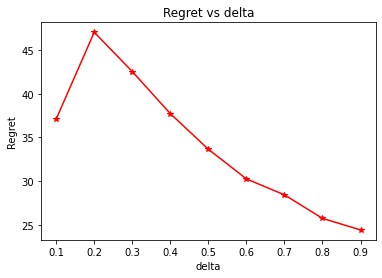

In [505]:
import matplotlib.pyplot as plt

regret_list = []
delta_list = np.arange(0.1, 1.0, 0.1)
for delta_ in delta_list:
    T = 1000
    optimal_arm = 0
    num_iter = 100000
    optimal_m = int(np.ceil(4*np.log(T*delta_**2/4)/delta_**2))
    regret_list.append(ETC(optimal_m, T, num_iter, optimal_arm, delta_))

plt.plot(delta_list, regret_list, 'r*-')
plt.title("Regret vs delta")
plt.xlabel("delta")
plt.ylabel("Regret")
plt.show()

### Q5.
5. Fix $\delta = 0.1$ and $T = 2,000$. Plot a graph showing how the ETC regret varies with $m$. In other words, we want to understand how the behavior of ETC changes when using suboptimal choices for $m$.
On the $x$-axis vary $m$ between 0 and 400 in increments of 50, and on the $y$-axis, show the average of ETC regret over $10^5$ reruns. 
<br></br>

ECB: T =  2000 , m =  50 , delta =  0.1
Best arm reward:  -56.7262720030493 , Average regret:  -3.54905793748191 Theoretical regret:  63.6321
-----------------------------------------------------------------------
ECB: T =  2000 , m =  100 , delta =  0.1
Best arm reward:  -41.26807131519821 , Average regret:  13.168192850704834 Theoretical regret:  53.4142
-----------------------------------------------------------------------
ECB: T =  2000 , m =  150 , delta =  0.1
Best arm reward:  -30.72227310610504 , Average regret:  22.19907380482821 Theoretical regret:  47.7828
-----------------------------------------------------------------------
ECB: T =  2000 , m =  200 , delta =  0.1
Best arm reward:  -24.135200581346197 , Average regret:  24.423685246522766 Theoretical regret:  45.7664
-----------------------------------------------------------------------
ECB: T =  2000 , m =  250 , delta =  0.1
Best arm reward:  -18.114235265078527 , Average regret:  32.13353694310524 Theoretical regret:

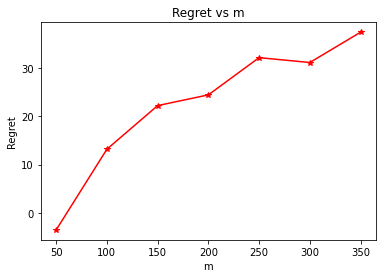

In [506]:
regret_list = []
m_list = np.arange(50, 400, 50)
for m in m_list:
    delta_ = .1
    T = 2000
    optimal_arm = 0
    num_iter = 100000
    regret_list.append(ETC(m, T, num_iter, optimal_arm, delta_))

plt.plot(m_list, regret_list, 'r*-')
plt.title("Regret vs m")
plt.xlabel("m")
plt.ylabel("Regret")
plt.show()

### Q6.
6. Plot the regret of UCB as a function of $\delta$ in a figure. Specifically, on the $x$-axis vary $\delta$ between 0 and 1 in increments of $0.1$, and on the $y$-axis, show the average of UCB regret over $10^5$ reruns.
On the same figure, add a line showing how the regret of ETC with $m=25$ varies as a function of $\delta$. Add four more lines on the same figure for ETC with $m = 50, 75, 100$, and 
the optimal choice of $m$ discussed on Page 6 of slides. Based on the results in the figure, how does the relative performance of UCB and ETC vary with $m$?
Further, comment on the importance of tuning $m$ if one uses ETC?
<br></br>

UCB: T =  1000 , delta =  0.1
Best arm reward:  0.676167783308016 , Average regret:  20.278720687087016 Theoretical regret:  20.286914000000003
-----------------------------------------------------------------------
ECB: T =  1000 , m =  25 , delta =  0.1
Best arm reward:  -32.66499210640965 , Average regret:  -15.956912388529616 Theoretical regret:  36.83395
-----------------------------------------------------------------------
ECB: T =  1000 , m =  50 , delta =  0.1
Best arm reward:  -25.75315706335111 , Average regret:  -0.9490235762699544 Theoretical regret:  32.7776
-----------------------------------------------------------------------
ECB: T =  1000 , m =  75 , delta =  0.1
Best arm reward:  -20.84001636867351 , Average regret:  5.689422588860637 Theoretical regret:  30.3344
-----------------------------------------------------------------------
ECB: T =  1000 , m =  100 , delta =  0.1
Best arm reward:  -17.167309188538667 , Average regret:  11.516996441571372 Theoretical regre

ECB: T =  1000 , m =  50 , delta =  0.7000000000000001
Best arm reward:  -0.030877949683338103 , Average regret:  35.14182089694963 Theoretical regret:  35.113400000000006
-----------------------------------------------------------------------
ECB: T =  1000 , m =  75 , delta =  0.7000000000000001
Best arm reward:  -0.018897368714237542 , Average regret:  52.42303256232991 Theoretical regret:  52.50595000000001
-----------------------------------------------------------------------
ECB: T =  1000 , m =  100 , delta =  0.7000000000000001
Best arm reward:  -0.11352353338717397 , Average regret:  70.00705205930305 Theoretical regret:  70.00000000000001
-----------------------------------------------------------------------
ECB: T =  1000 , m =  40 , delta =  0.7000000000000001
Best arm reward:  -0.47510376697883994 , Average regret:  28.4679660619046 Theoretical regret:  28.586040000000004
-----------------------------------------------------------------------
UCB: T =  1000 , delta =  0.

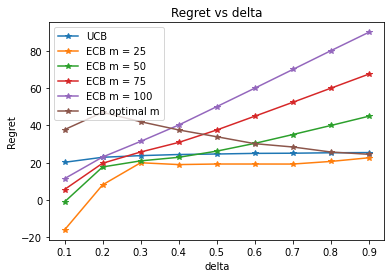

In [507]:
regret_list_UCB = []
regret_list_ETC_m25 = []
regret_list_ETC_m50 = []
regret_list_ETC_m75 = []
regret_list_ETC_m100 = []
regret_list_ETC_mopt = []
delta_list = np.arange(0.1, 1.0, 0.1)
for delta_ in delta_list:
    T = 1000
    optimal_arm = 0
    num_iter = 100000
    optimal_m = int(np.ceil(4*np.log(T*delta_**2/4)/delta_**2))
    regret_list_UCB.append(UCB(T, num_iter, optimal_arm, delta_))
    regret_list_ETC_m25.append(ETC(25, T, num_iter, optimal_arm, delta_))
    regret_list_ETC_m50.append(ETC(50, T, num_iter, optimal_arm, delta_))
    regret_list_ETC_m75.append(ETC(75, T, num_iter, optimal_arm, delta_))
    regret_list_ETC_m100.append(ETC(100, T, num_iter, optimal_arm, delta_))
    regret_list_ETC_mopt.append(ETC(optimal_m, T, num_iter, optimal_arm, delta_))
    
plt.plot(delta_list, regret_list_UCB, '*-',
         delta_list, regret_list_ETC_m25, '*-',
         delta_list, regret_list_ETC_m50, '*-',
         delta_list, regret_list_ETC_m75, '*-',
         delta_list, regret_list_ETC_m100, '*-',
         delta_list, regret_list_ETC_mopt, '*-')

plt.title("Regret vs delta")
plt.xlabel("delta")
plt.ylabel("Regret")
plt.legend(["UCB", "ECB m = 25", "ECB m = 50", "ECB m = 75", "ECB m = 100", "ECB optimal m"])
plt.show()

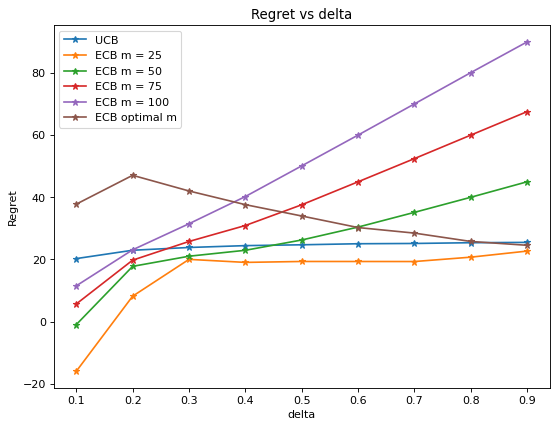

In [510]:
plt.figure(figsize=(8, 6), dpi=80)

plt.plot(delta_list, regret_list_UCB, '*-',
         delta_list, regret_list_ETC_m25, '*-',
         delta_list, regret_list_ETC_m50, '*-',
         delta_list, regret_list_ETC_m75, '*-',
         delta_list, regret_list_ETC_m100, '*-',
         delta_list, regret_list_ETC_mopt, '*-')

plt.title("Regret vs delta")
plt.xlabel("delta")
plt.ylabel("Regret")
plt.legend(["UCB", "ECB m = 25", "ECB m = 50", "ECB m = 75", "ECB m = 100", "ECB optimal m"])
plt.show()

As it is evident with the plot, the optimal m gives a much lower regret comparing to other suboptimal m values. Also, as optimal m changes with delta, the value of regret decreases by delta in contrast to other m values.